<a href="https://colab.research.google.com/github/amedekaemperor/PyTorch/blob/main/intro_to_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Modeling the Deflection of a Cantilever Beam**

In [1]:
!pip3 install torch matplotlib numpy --user

![](https://ilearnengineering.com/wp-content/uploads/2023/10/Picture-1.png)

In [2]:
import torch
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

# parameters
P = 1000 # load (N)
L = 5 # beam length (m)
E = 200e9 # Young's modulus (Pa)
I = 1e-5 # moment of inertial (m^4)

x = torch.linspace(0, L, 100) # distance from fixed end
y_true = -(P * x**2) / (6 * E * I) * (3 * L - x) # true deflection
y_noisy = y_true + 1e-3 * torch.randn(100) # noisy deflection

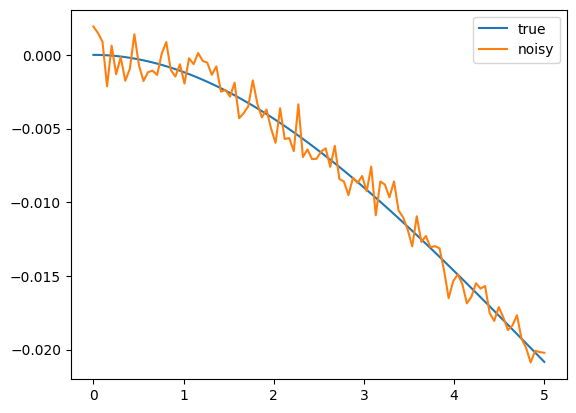

In [3]:
import matplotlib.pyplot as plt

plt.plot(x, y_true, label='true')
plt.plot(x, y_noisy, label='noisy')
plt.legend()
plt.show()

In [4]:
X = x.unsqueeze(1) # reshape to 10x1

model = torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16, 1) # predicted deflection
)

model

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

Epoch 0, loss 0.003028044942766428
Epoch 500, loss 1.1446691132732667e-06
Epoch 1000, loss 1.0544664519329672e-06


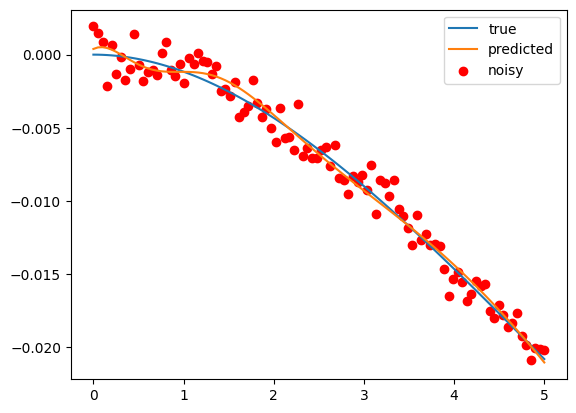

In [5]:
loss = torch.nn.MSELoss() # mean squred error loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # adam

# trainig loop
for epoch in range(1500):
    y_pred = model(X) # predict deflection
    loss_value = loss(y_pred, y_noisy.unsqueeze(1)) # calculate loss
    optimizer.zero_grad() # reset gradients
    loss_value.backward() # backpropagate
    optimizer.step() # update weights

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, loss {loss_value.item()}')

y_pred = model(X).detach().numpy() # predict deflection
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='predicted')
plt.scatter(x, y_noisy, label='noisy', color='red')
plt.legend()
plt.show()

## **Model initializes beam deflection at $x=0$ as non-zero. Adding physcis constraints**

Epoch 0, loss 2.528993718442507e-06
Epoch 500, loss 1.0102211263074423e-06
Epoch 1000, loss 1.0008843673858792e-06


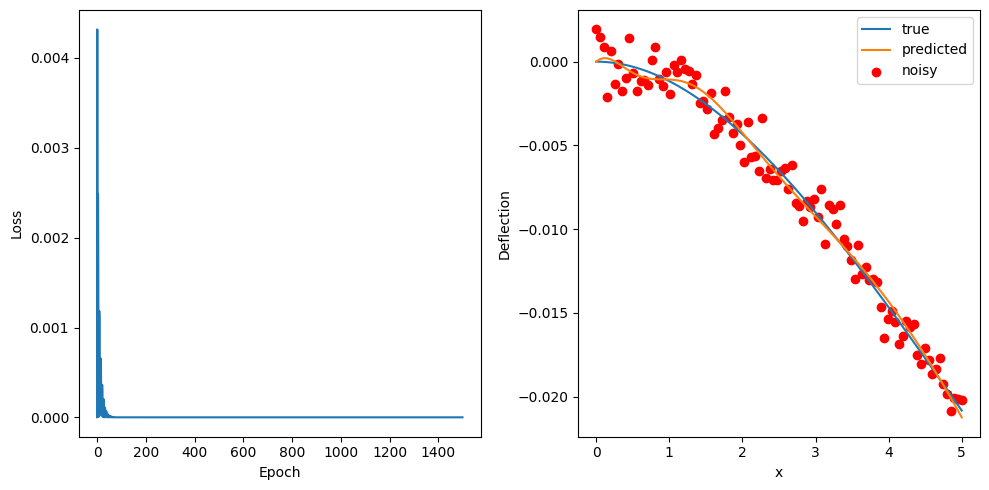

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # adam

def physics_loss(y_pred, y_true):
    y_pred = y_pred.squeeze()
    y_true = y_true.squeeze()
    loss = torch.mean((y_pred - y_true)**2)

    # boundary loss (y_pred[x==0] = 0)
    alpha = 10
    return loss + (y_pred[0] - 0)**2 * alpha

loss = []
# training loop
for epoch in range(1500):
    y_pred = model(X) # predict deflection
    loss_value = physics_loss(y_pred, y_noisy.unsqueeze(1)) # calculate loss
    optimizer.zero_grad() # reset gradients
    loss_value.backward() # backpropagate
    optimizer.step() # update weights
    loss.append(loss_value.item())

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, loss {loss_value.item()}')

y_pred = model(X).detach().numpy() # predict deflection

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(x, y_true, label='true')
plt.plot(x, y_pred, label='predicted')
plt.scatter(x, y_noisy, label='noisy', color='red')
plt.xlabel('x')
plt.ylabel('Deflection')
plt.legend()
plt.tight_layout()
plt.show()

## **Modeling of a 2D surface :$f=sin(x)*sin(y)$**

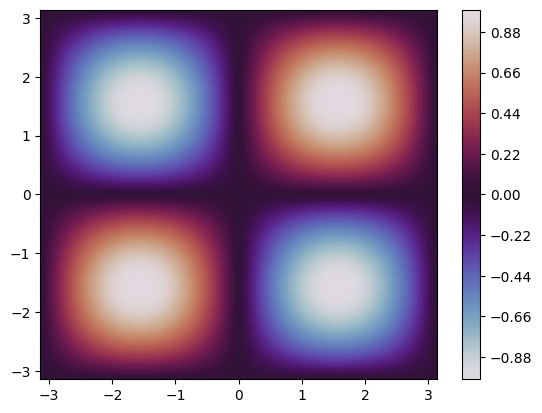

In [11]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch

x, y = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
f = np.sin(x) * np.sin(y)
x, y, f = torch.tensor(x.flatten()).float().view(-1, 1), torch.tensor(y.flatten()).float().view(-1, 1), torch.tensor(f.flatten()).float().view(-1, 1)

# Convert PyTorch tensors to NumPy arrays before plotting
plt.contourf(x.view(50, 50).detach().numpy(),
             y.view(50, 50).detach().numpy(),
             f.view(50, 50).detach().numpy(),
             100, cmap='twilight') # Detach from computation graph and convert to NumPy
plt.colorbar()
plt.show()

In [10]:
class StandardNN(nn.Module):
    def __init__(self):
        super(StandardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )


    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.layers(xy)

model = StandardNN()
model

StandardNN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

Epoch 0, loss 0.48994970321655273
Epoch 500, loss 0.05213746428489685
Epoch 1000, loss 0.01858636550605297
Epoch 1500, loss 0.0031083712819963694
Epoch 2000, loss 0.0008858179789967835
Epoch 2500, loss 0.0005634180270135403
Epoch 3000, loss 0.0004385826177895069
Epoch 3500, loss 0.00034206552663818
Epoch 4000, loss 0.0003063838230445981
Epoch 4500, loss 0.00022584815451409668


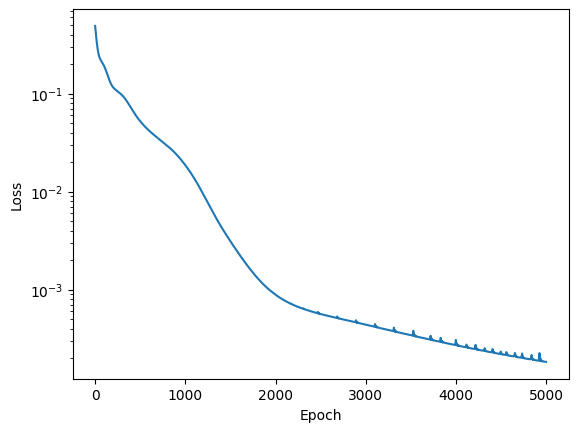

In [12]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
for epoch in range(5000):
    optimizer.zero_grad()
    f_pred = model(x, y)
    loss_value = loss(f_pred, f)
    loss_value.backward()
    optimizer.step()
    losses.append(loss_value.item())

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, loss {loss_value.item()}')

plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

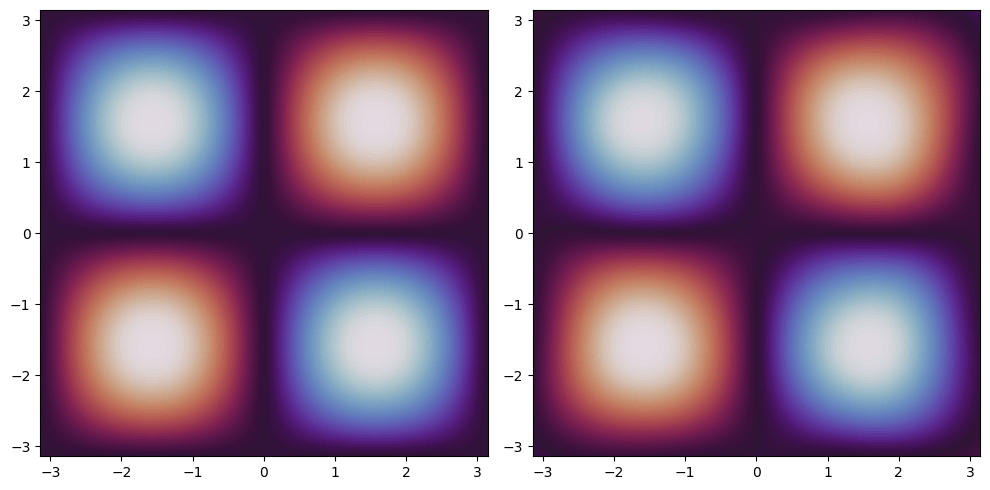

In [16]:
x, y = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
f = np.sin(x) * np.sin(y)
x, y, f = torch.tensor(x.flatten()).float().view(-1, 1), torch.tensor(y.flatten()).float().view(-1, 1), torch.tensor(f.flatten()).float().view(-1, 1)

f_pred = model(x, y)
f_pred = f_pred.detach().numpy().reshape(50, 50)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Detach from computation graph and convert to NumPy before plotting
plt.contourf(x.view(50, 50).detach().numpy(),
             y.view(50, 50).detach().numpy(),
             f.view(50, 50).detach().numpy(),
             100, cmap='twilight')
plt.subplot(1, 2, 2)
plt.contourf(x.view(50, 50).detach().numpy(), y.view(50, 50).detach().numpy(), f_pred, 100, cmap='twilight')
plt.tight_layout()
plt.show()

## **Extrapolating from $-2\pi$ to $2\pi $**

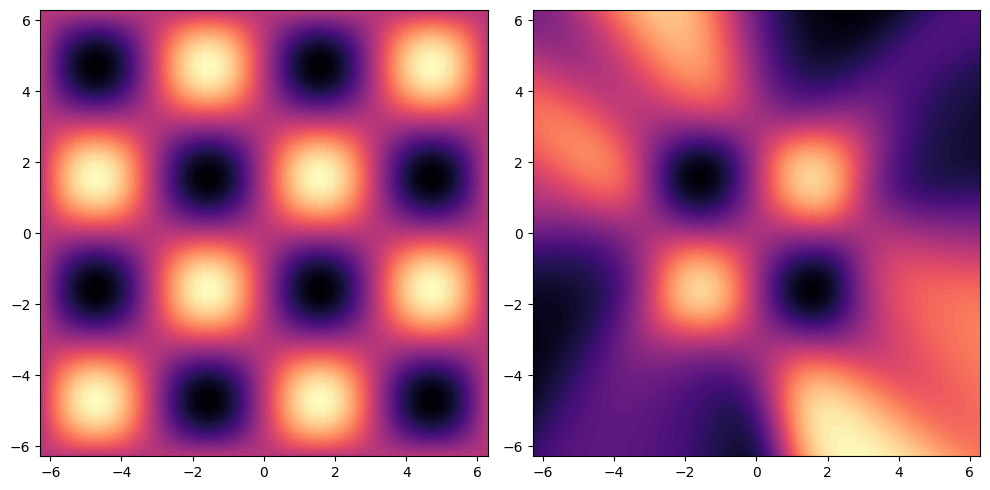

In [19]:
x, y = np.meshgrid(np.linspace(-2*np.pi, 2*np.pi, 50), np.linspace(-2*np.pi, 2*np.pi, 50))
f = np.sin(x) * np.sin(y)
x, y, f = torch.tensor(x.flatten()).float().view(-1, 1), torch.tensor(y.flatten()).float().view(-1, 1), torch.tensor(f.flatten()).float().view(-1, 1)

f_pred = model(x, y)
f_pred = f_pred.detach().numpy().reshape(50, 50)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Convert tensors to NumPy arrays before plotting
plt.contourf(x.view(50, 50).detach().numpy(),  # Detach and convert to NumPy
             y.view(50, 50).detach().numpy(),  # Detach and convert to NumPy
             f.view(50, 50).detach().numpy(),  # Detach and convert to NumPy
             100, cmap='magma')

plt.subplot(1, 2, 2)
plt.contourf(x.view(50, 50).detach().numpy(), y.view(50, 50).detach().numpy(), f_pred, 100, cmap='magma')
plt.tight_layout()
plt.show()

## **Finding the derivatives**

In [20]:
import sympy as sp
x, y = sp.symbols('x y')
f = sp.sin(x) * sp.sin(y) # f = sin(x) * sin(y)
grad2_f = sp.diff(f, x, 2) + sp.diff(f, y, 2) # second derivative with respect to x and y
grad2_f

-2*sin(x)*sin(y)

In [21]:
2*f + grad2_f

0

In [22]:
# f(x) = x^2, finding f'(3) and f''(3)

x = torch.tensor([3.], requires_grad=True)
f = x**2
dfdx = torch.autograd.grad(f, x, create_graph=True)[0]
df2dx2 = torch.autograd.grad(dfdx, x)[0]
dfdx[0], df2dx2[0]

(tensor(6., grad_fn=<SelectBackward0>), tensor(2.))

## **Creating a PINN model**

In [23]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.layers(xy)

    def loss(self, x, y):
        f = self.forward(x, y)
        f_x = torch.autograd.grad(f.sum(), x, create_graph=True)[0]
        f_xx = torch.autograd.grad(f_x.sum(), x, create_graph=True)[0]
        f_y = torch.autograd.grad(f.sum(), y, create_graph=True)[0]
        f_yy = torch.autograd.grad(f_y.sum(), y, create_graph=True)[0]

        pde_loss = f_xx + f_yy + 2 * f
        return torch.mean((f - torch.sin(x) * torch.sin(y))**2) + torch.mean(pde_loss**2)


In [24]:
x, y = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
x, y = torch.tensor(x.flatten(), requires_grad=True).float().view(-1, 1), torch.tensor(y.flatten(), requires_grad=True).float().view(-1, 1)

Epoch 0, loss 0.6237627267837524
Epoch 500, loss 0.15974602103233337
Epoch 1000, loss 0.040956564247608185
Epoch 1500, loss 0.011103078722953796
Epoch 2000, loss 0.007250971160829067
Epoch 2500, loss 0.0049339416436851025
Epoch 3000, loss 0.004089470487087965
Epoch 3500, loss 0.0029381646309047937
Epoch 4000, loss 0.0024599884636700153
Epoch 4500, loss 0.0021063692402094603


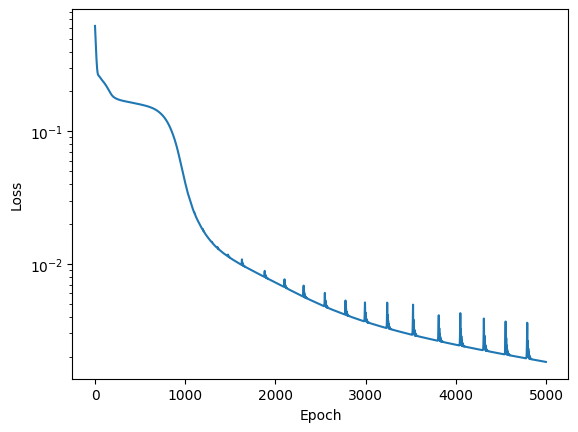

In [25]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
for epoch in range(5000):
    optimizer.zero_grad()
    loss_value = model.loss(x, y)
    loss_value.backward()
    optimizer.step()
    losses.append(loss_value.item())

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, loss {loss_value.item()}')

plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

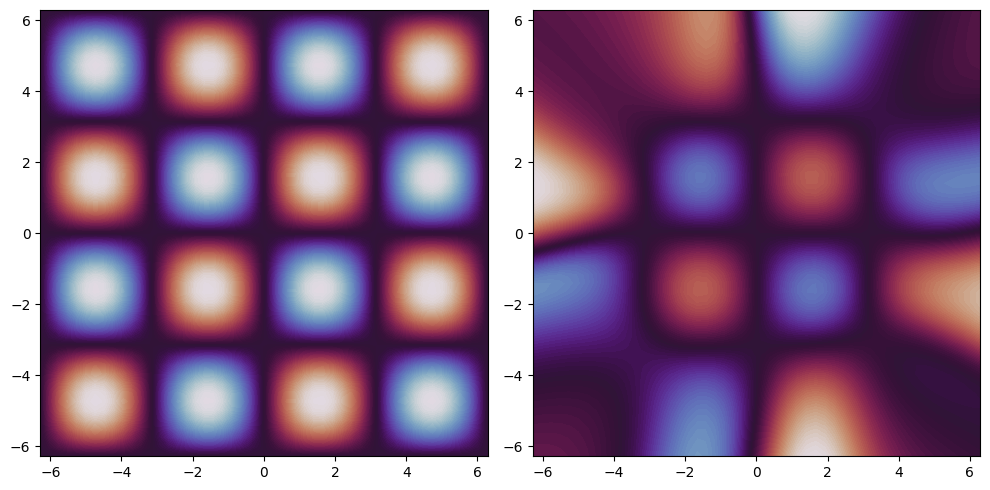

In [27]:
x, y = np.meshgrid(np.linspace(-2*np.pi, 2*np.pi, 50), np.linspace(-2*np.pi, 2*np.pi, 50))
f = np.sin(x) * np.sin(y)
x, y, f = torch.tensor(x.flatten()).float().view(-1, 1), torch.tensor(y.flatten()).float().view(-1, 1), torch.tensor(f.flatten()).float().view(-1, 1)

f_pred = model(x, y)

# Convert PyTorch tensors to NumPy arrays before plotting
x_np = x.detach().numpy().reshape(50, 50)  # Detach and convert to NumPy
y_np = y.detach().numpy().reshape(50, 50)  # Detach and convert to NumPy
f_np = f.detach().numpy().reshape(50, 50)  # Detach and convert to NumPy
f_pred_np = f_pred.detach().numpy().reshape(50, 50) # Detach and convert to NumPy


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

# Use NumPy arrays for plotting
plt.contourf(x_np, y_np, f_np, 100, cmap='twilight')

plt.subplot(1, 2, 2)

# Use NumPy arrays for plotting
plt.contourf(x_np, y_np, f_pred_np, 100, cmap='twilight')
plt.tight_layout()
plt.show()